In [11]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import re

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
CLASSES: dict[int, str] = {
    -1: "None",
    0: "Spam/Scam/Garbage",
    1: "Non-Complaint ",
    # -- Rest are complaints --
    2: "Delay",
    3: "Hygeine (food, toilets, carriage)",
    4: "Ticket issue (cancellation, refund, seat change)",
    5: "Medical issue",
    6: "Safety issue",
    7: "Travel Experience",
    8: "Feedback / Suggestions (less critical/urgent)",
}
URGENCY: dict[int, str] = {
    -1: "None",
    0: "Low",
    1: "Pressing",
    2: "Critical",
}
LANG: dict[int, str] = {
    -1: "None",
    0: "English",
    1: "Hindi (devanagari; purely)",
    2: "Hinglish (devanagari; with english in latin alphabet)",
    3: "Hinglish (devanagari; with english transliterated to hindi)",
    4: "Hinglish (latin; with hindi transliterated to english)",
}

### BERT-BiLSTM complaint/non-complaint


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import gc

/home/risb/Desktop/BTP2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_urg = pd.read_csv("eng_data_c_urg.csv")

NaN (float) to empty string

In [4]:
for idx, i in enumerate(df_urg.loc[:, "SentimentText"]):
    if type(i) == float:
        df_urg.loc[idx, "SentimentText"] = ""

In [5]:
import time 

train_texts_urg, val_texts_urg, train_labels_urg, val_labels_urg = train_test_split(
    df_urg['SentimentText'].tolist(), df_urg['urgency'].tolist(), test_size=0.2, random_state=(time.time_ns() % 943024), stratify=df_urg['urgency']
)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.input_ids = torch.tensor(encodings['input_ids'])
        self.attention_mask = torch.tensor(encodings['attention_mask'])
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
    
train_dataset_urg = TextDataset(train_texts_urg, train_labels_urg)
val_dataset_urg = TextDataset(val_texts_urg, val_labels_urg)

train_loader_urg = DataLoader(train_dataset_urg, batch_size=32, shuffle=True)
val_loader_urg = DataLoader(val_dataset_urg, batch_size=32)

In [3]:
# class BERTBiLSTM(nn.Module):
#     def __init__(self, num_classes, hidden_dim=128, lstm_layers=1, dropout=0.3):
#         super(BERTBiLSTM, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=lstm_layers,
#                             batch_first=True, bidirectional=True)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(hidden_dim * 2, num_classes)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         sequence_output = outputs.last_hidden_state
#         lstm_output, _ = self.lstm(sequence_output)
#         pooled_output = torch.mean(lstm_output, dim=1)
#         x = self.dropout(pooled_output)
#         return self.fc(x)

from transformers import PreTrainedModel, PretrainedConfig

class BertBiLSTMConfig(PretrainedConfig):
    model_type = "bert_bilstm"
    def __init__(self, num_classes=2, hidden_dim=128, lstm_layers=1, dropout=0.3, **kwargs):
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        super().__init__(**kwargs)

class BERTBiLSTM(PreTrainedModel):
    config_class = BertBiLSTMConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=config.hidden_dim,
            num_layers=config.lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(config.dropout)
        self.fc = nn.Linear(config.hidden_dim * 2, config.num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        pooled_output = torch.mean(lstm_output, dim=1)
        x = self.dropout(pooled_output)
        return self.fc(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(df_urg['urgency'].value_counts())
model = BERTBiLSTM(BertBiLSTMConfig(num_classes=num_classes, lstm_layers=1, hidden_dim=128)).to(device)

EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.01)
total_steps = len(train_loader_urg) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()

In [10]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader_urg, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_urg)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_preds, val_targets = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader_urg, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    print(f"Epoch {epoch+1} Validation Accuracy: {val_acc:.4f}")





Training Epoch 1/4: 100%|██████████| 38/38 [00:30<00:00,  1.23it/s]


Epoch 1 Train Loss: 0.9548


Validation Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Epoch 1 Validation Accuracy: 0.5667


Training Epoch 2/4: 100%|██████████| 38/38 [00:30<00:00,  1.25it/s]


Epoch 2 Train Loss: 0.8613


Validation Epoch 2: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Epoch 2 Validation Accuracy: 0.6167


Training Epoch 3/4: 100%|██████████| 38/38 [00:30<00:00,  1.24it/s]


Epoch 3 Train Loss: 0.6762


Validation Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Epoch 3 Validation Accuracy: 0.6033


Training Epoch 4/4: 100%|██████████| 38/38 [00:30<00:00,  1.24it/s]


Epoch 4 Train Loss: 0.4574


Validation Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

Epoch 4 Validation Accuracy: 0.6100


In [18]:
print("\nClassification Report:")
labels = list(URGENCY.values())[1:]
print(classification_report(val_targets, val_preds, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

         Low       0.67      0.66      0.67       143
    Pressing       0.56      0.64      0.60       130
    Critical       0.45      0.19      0.26        27

    accuracy                           0.61       300
   macro avg       0.56      0.50      0.51       300
weighted avg       0.61      0.61      0.60       300



In [1]:
# Confusion Matrix
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
# plt.title('Urgency Classification Confusion Matrix')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [20]:
model.save_pretrained("bert_bilstm_urgency_classifier")
tokenizer.save_pretrained("bert_bilstm_urgency_classifier")

import pickle

with open('val_labels_urg_bi.pkl', 'wb') as file:
    pickle.dump(val_labels_urg, file)
with open('val_texts_urg_bi.pkl', 'wb') as file:
    pickle.dump(val_texts_urg, file)


In [15]:
import gc

In [16]:
try: model.cpu()
except: pass

try: del model
except: pass

try: del optimizer
except: pass

try: del scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader, nn, AdamW
except: pass


gc.collect()

4684

In [17]:
! nvidia-smi

Fri May  9 02:05:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| N/A   66C    P0             N/A / 5001W |     773MiB /   4096MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModel, AutoTokenizer, AutoConfig
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import re, pickle

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
model = BERTBiLSTM.from_pretrained("bert_bilstm_urgency_classifier")
tokenizer = AutoTokenizer.from_pretrained("bert_bilstm_urgency_classifier")

In [17]:
model.to(device)

BERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [18]:
with open('val_texts_urg_bi.pkl', 'rb') as file:
    val_texts_urg = pickle.load(file)  # Deserialize[2][6]
print(val_texts_urg)  # Output: {'name': 'Alice', ...}
with open('val_labels_urg_bi.pkl', 'rb') as file:
    val_labels_urg = pickle.load(file)  # Deserialize[2][6]
print(val_labels_urg)  # Output: {'name': 'Alice', ...}

['my oldagd mother trvlng wht 2 child . in magadheprss from pnbe to ndls . . out of communication last 10 hours . please hlp', 'kindly conduct routine ticket checking passenger train between saharanpur to delhi . via meerut . lost of people without ticket', 'sir ples allot wdp4 loco of 19027 bandra jamu tawi vivek express . from adi to jat . ples allot .', '. 2 a seats 3,4 , 5,6 . ticket printed as 2 lower berth 2 upper berth on tickets but in 2 air conditioner 5 and 6 are side seats . is that possible ?', 'i was expecting some strict action on overcharging but instead received a mail stating counseling will be done for them .', 'trying to book a tatkal ticket from last 3 day but daily same problem exist . please do some needful', 'sir condition of railway colony bareilly junction . for past 5 days . please help', 'kinly help with irctc refund doing follow up with irctc since 2 4th may .', 'need some help in teain number 12192 as our bag was stolen and no police is available to file a 

In [19]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.input_ids = torch.tensor(encodings['input_ids'])
        self.attention_mask = torch.tensor(encodings['attention_mask'])
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

val_dataset_urg = TextDataset(val_texts_urg, val_labels_urg)
val_loader_urg = DataLoader(val_dataset_urg, batch_size=32)

In [20]:
def evaluate(model, val_loader):
    model.eval()
    val_preds, val_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    return (val_targets, val_preds)

(val_targets, val_preds) = evaluate(model, val_loader_urg)

In [21]:
print("\nClassification Report:")
labels = list(URGENCY.values())[1:]
print(classification_report(val_targets, val_preds, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

         Low       0.67      0.66      0.67       143
    Pressing       0.56      0.64      0.60       130
    Critical       0.45      0.19      0.26        27

    accuracy                           0.61       300
   macro avg       0.56      0.50      0.51       300
weighted avg       0.61      0.61      0.60       300



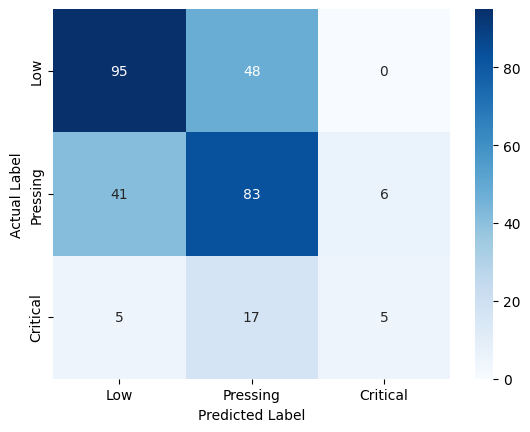

In [23]:
cm = confusion_matrix(val_targets, val_preds)
# plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
# plt.title('Confusion Matrix')
plt.show()

In [ ]:
import gc
try: model.cpu()
except: pass

try: del model
except: pass

try: del optimizer
except: pass

try: del scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader, nn, AdamW
except: pass


gc.collect()

4307